In [2]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
# Load the Data

data_dir = pathlib.Path('./data/tiny-imagenet-200')
image_count = len(list(data_dir.glob('**/*.JPEG')))
CLASS_NAMES = np.array([item.name for item in (data_dir / 'train').glob('*')])
num_classes = len(CLASS_NAMES)
print('Discovered {} images in {} classes'.format(image_count, num_classes))

# Create the training data generator
batch_size = 32
im_height = 64
im_width = 64
num_epochs = 1

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
])

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=data_dir / 'train', transform=data_transforms),
    'valid': datasets.ImageFolder(root=data_dir / 'val', transform=data_transforms),
    'test': datasets.ImageFolder(root=data_dir / 'test', transform=data_transforms)
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

Discovered 129998 images in 200 classes
{0: 'n01443537', 1: 'n01629819', 2: 'n01641577', 3: 'n01644900', 4: 'n01698640', 5: 'n01742172', 6: 'n01768244', 7: 'n01770393', 8: 'n01774384', 9: 'n01774750', 10: 'n01784675', 11: 'n01855672', 12: 'n01882714', 13: 'n01910747', 14: 'n01917289', 15: 'n01944390', 16: 'n01945685', 17: 'n01950731', 18: 'n01983481', 19: 'n01984695', 20: 'n02002724', 21: 'n02056570', 22: 'n02058221', 23: 'n02074367', 24: 'n02085620', 25: 'n02094433', 26: 'n02099601', 27: 'n02099712', 28: 'n02106662', 29: 'n02113799', 30: 'n02123045', 31: 'n02123394', 32: 'n02124075', 33: 'n02125311', 34: 'n02129165', 35: 'n02132136', 36: 'n02165456', 37: 'n02190166', 38: 'n02206856', 39: 'n02226429', 40: 'n02231487', 41: 'n02233338', 42: 'n02236044', 43: 'n02268443', 44: 'n02279972', 45: 'n02281406', 46: 'n02321529', 47: 'n02364673', 48: 'n02395406', 49: 'n02403003', 50: 'n02410509', 51: 'n02415577', 52: 'n02423022', 53: 'n02437312', 54: 'n02480495', 55: 'n02481823', 56: 'n02486410', 

In [12]:
# Load pretrained ResNet50 Model
model = models.resnet50(pretrained=False)

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# Convert model to be used on GPU
model = model.to('cuda:0')


best_model_path = "./model_best.pth.tar"
# model = torch.load(best_model_path)
state_dict = torch.load(best_model_path)['state_dict']
model.load_state_dict({k[7:]: v for k, v in state_dict.items()})
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

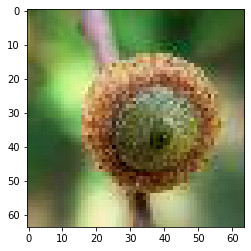

In [15]:
from PIL import Image
import skimage.transform

image = Image.open("./data/tiny-imagenet-200/train/n12267677/images/n12267677_139.JPEG")
plt.imshow(image)

In [16]:
tensor = data_transforms(image)

In [17]:
from torch.autograd import Variable
prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)

In [18]:
# Taken from http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()

In [19]:
final_layer = model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)

In [21]:
prediction = model(prediction_var)
pred_probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
activated_features.remove()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [40]:
torch.topk(pred_probabilities,2)

torch.return_types.topk(
values=tensor([0.4213, 0.0701], device='cuda:0'),
indices=tensor([113,  43], device='cuda:0'))

In [27]:
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [28]:
weight_softmax_params = list(model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

In [29]:
weight_softmax_params

[Parameter containing:
 tensor([[-0.0252,  0.0161, -0.0103,  ...,  0.0241,  0.0010, -0.0219],
         [-0.0014, -0.0106, -0.0038,  ..., -0.0160, -0.0195, -0.0186],
         [-0.0056, -0.0151, -0.0101,  ..., -0.0224, -0.0171, -0.0217],
         ...,
         [-0.0104,  0.0253,  0.0063,  ...,  0.0164,  0.0280,  0.0158],
         [-0.0025, -0.0139, -0.0026,  ...,  0.0020,  0.0123,  0.0044],
         [-0.0113, -0.0101,  0.0124,  ..., -0.0229,  0.0055,  0.0287]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([ 2.9233e-02,  1.2629e-02, -1.2537e-02,  5.4563e-03,  2.2138e-02,
          1.2826e-02,  3.0126e-02,  1.0025e-03, -1.8736e-02, -1.0931e-02,
          2.1182e-02, -1.9994e-02, -2.3833e-03,  1.9666e-02,  6.4957e-03,
         -3.6153e-03,  2.5847e-02,  9.8194e-03, -4.5119e-03, -1.9305e-03,
          1.6378e-02,  6.6612e-03,  1.7767e-02,  1.6780e-02, -5.5007e-03,
         -6.5330e-03,  1.1877e-02,  1.3833e-02,  2.2999e-02,  2.4825e-02,
         -2.0114e-02, -2

In [32]:
class_idx = torch.topk(pred_probabilities,1)[1].int()
print(class_idx)

tensor([113], device='cuda:0', dtype=torch.int32)


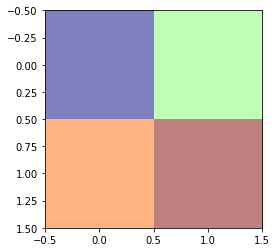

In [33]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)
plt.imshow(overlay[0], alpha=0.5, cmap='jet')

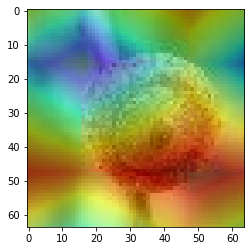

In [34]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(overlay[0], tensor.shape[1:3]), alpha=0.5, cmap='jet')

In [61]:
# Taken from http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html

class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()
        
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

def getTopKCAM(model, image, k):
    titles_to_show = ["Original"]
    images_to_show = [image]
    
    tensor = data_transforms(image)
    prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    
    prediction = model(prediction_var)
    pred_probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
    activated_features.remove()
    
    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())
    
    topk_classes = torch.topk(pred_probabilities, k)
    
    for i in range(k):
        confidence_idx = topk_classes[0][i].float()
        class_idx = topk_classes[1][i].int()
        overlay = getCAM(activated_features.features, weight_softmax, class_idx)
        
        titles_to_show.append("#{0} Class = {1}\nConf = {2:0.3f}".format(i+1, class_idx, confidence_idx))
        images_to_show.append(skimage.transform.resize(overlay[0], tensor.shape[1:3]))
    
    fig, axes = plt.subplots(1, k+1, sharey=True)
    axes[0].imshow(images_to_show[0])
    axes[0].set_title(titles_to_show[0])
    for i in range(k):
        axes[i+1].imshow(images_to_show[0])
        axes[i+1].imshow(images_to_show[i+1], alpha=0.5, cmap='jet')
        axes[i+1].set_title(titles_to_show[i+1])
    fig.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


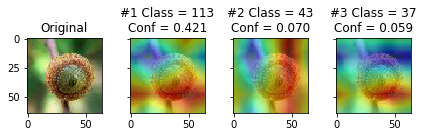

In [62]:
getTopKCAM(model, image, 3)

In [71]:
import shutil
import os

# List of TinyImageNet classes
tiny_imagenet_classes = os.listdir("./data/tiny-imagenet-200/train/")

idx_to_class_map = {}
class_to_name_map = {}
with open('./data/tiny-imagenet-200/words.txt', "r") as f:
    i = 0
    for line in f:
        one_line = line.split()
        if one_line[0] in tiny_imagenet_classes:
            idx_to_class_map[i] = one_line[0]
            class_name = " ".join(one_line[1:]).split(',')[0]
            class_to_name_map[one_line[0]] = class_name
            i += 1
print({k: class_to_name_map[v] for k, v in idx_to_class_map.items()})

{0: 'goldfish', 1: 'European fire salamander', 2: 'bullfrog', 3: 'tailed frog', 4: 'American alligator', 5: 'boa constrictor', 6: 'trilobite', 7: 'scorpion', 8: 'black widow', 9: 'tarantula', 10: 'centipede', 11: 'goose', 12: 'koala', 13: 'jellyfish', 14: 'brain coral', 15: 'snail', 16: 'slug', 17: 'sea slug', 18: 'American lobster', 19: 'spiny lobster', 20: 'black stork', 21: 'king penguin', 22: 'albatross', 23: 'dugong', 24: 'Chihuahua', 25: 'Yorkshire terrier', 26: 'golden retriever', 27: 'Labrador retriever', 28: 'German shepherd', 29: 'standard poodle', 30: 'tabby', 31: 'Persian cat', 32: 'Egyptian cat', 33: 'cougar', 34: 'lion', 35: 'brown bear', 36: 'ladybug', 37: 'fly', 38: 'bee', 39: 'grasshopper', 40: 'walking stick', 41: 'cockroach', 42: 'mantis', 43: 'dragonfly', 44: 'monarch', 45: 'sulphur butterfly', 46: 'sea cucumber', 47: 'guinea pig', 48: 'hog', 49: 'ox', 50: 'bison', 51: 'bighorn', 52: 'gazelle', 53: 'Arabian camel', 54: 'orangutan', 55: 'chimpanzee', 56: 'baboon', 57

In [80]:
def getTopKCAMMultipleImages(model, image_paths, k):
    fig, axes = plt.subplots(len(image_paths), k+1, sharey=True, figsize=(15,15))
    
    for image_idx, image_path in enumerate(image_paths):
        image = Image.open(image_path)
        
        titles_to_show = ["Original"]
        images_to_show = [image]

        tensor = data_transforms(image)
        prediction_var = Variable((tensor.unsqueeze(0)).cuda(), requires_grad=True)
        final_layer = model._modules.get('layer4')
        activated_features = SaveFeatures(final_layer)

        prediction = model(prediction_var)
        pred_probabilities = torch.nn.functional.softmax(prediction).data.squeeze()
        activated_features.remove()

        weight_softmax_params = list(model._modules.get('fc').parameters())
        weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

        topk_classes = torch.topk(pred_probabilities, k)

        for i in range(k):
            confidence_idx = topk_classes[0][i].float()
            class_idx = topk_classes[1][i].int()
            overlay = getCAM(activated_features.features, weight_softmax, class_idx)

            class_name = class_to_name_map[idx_to_class_map[int("{}".format(class_idx))]]
            titles_to_show.append("#{0} Class = {1}\nConf = {2:0.3f}".format(i+1, class_name, confidence_idx))
            images_to_show.append(skimage.transform.resize(overlay[0], tensor.shape[1:3]))

        axes[image_idx, 0].imshow(images_to_show[0])
        axes[image_idx, 0].set_title(titles_to_show[0])
        for i in range(k):
            axes[image_idx, i+1].imshow(images_to_show[0])
            axes[image_idx, i+1].imshow(images_to_show[i+1], alpha=0.5, cmap='jet')
            axes[image_idx, i+1].set_title(titles_to_show[i+1])
        fig.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


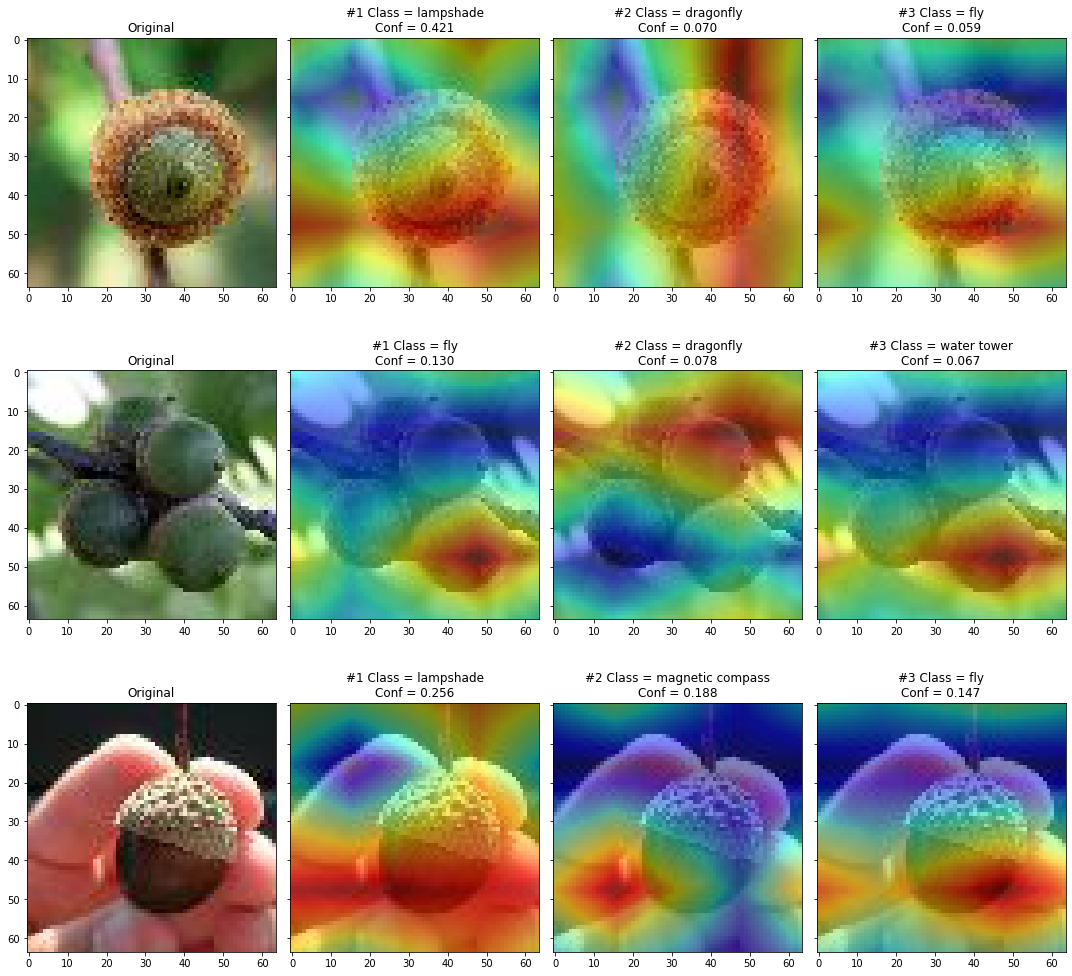

In [81]:
image_paths = ["./data/tiny-imagenet-200/train/n12267677/images/n12267677_139.JPEG",
               "./data/tiny-imagenet-200/train/n12267677/images/n12267677_353.JPEG",
               "./data/tiny-imagenet-200/train/n12267677/images/n12267677_268.JPEG"]

getTopKCAMMultipleImages(model, image_paths, 3)